<a href="https://colab.research.google.com/github/nyp-sit/sdaai-pdc2-students/blob/master/iti107/session-3/improved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Simpsons Characters recognition using transfer learning (VGG19)

The Simpsons Characters dataset is obtained from https://www.kaggle.com/alexattia/the-simpsons-characters-dataset.
I only used 23 characters from the dataset. There are 13495 images for the 23 characters.

I use transfer learning in the  baseline model for this experiment. I make use of the model (VGG19) that is already trained on ImageNet and use the convolutional layers as feature extractor and trained a classifier specifically for the Simpsons Characters classification task. The training was done using Nvidia GTX 1660 TI GPU.


In [1]:
from __future__ import print_function

import os
import json
import shutil
import numpy as np

from utils import prepare_data

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, \
                            precision_recall_curve, average_precision_score, confusion_matrix
import pickle
import matplotlib
import matplotlib.pyplot as plt


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

%matplotlib inline

## Prepare Data

Unzip the temp_data.zip into a temp_data folder. The utils.py will split the images to training and validation sets.

In [2]:
data_path = "data"
models_path = "models"
valid_size = 0.2
FORCED_DATA_REWRITE = False

In [3]:
train_path, valid_path = prepare_data(data_path=data_path, 
                                      valid_size=valid_size, 
                                      FORCED_DATA_REWRITE=FORCED_DATA_REWRITE)

In [4]:
img_height, img_width = 300, 400

## Pre-trained Model as Feature Extractor

I use VGG19 as our pretrained model (you can choose any other pretrained model, such as ResNet, etc). Keras comes with a set of [pretrained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) you can choose from. In the following call, I load the model VGG19 without including the classification layers (`include_top=False`). For the weights, I specify to use the weights that was trained on ImageNet dataset.

In [5]:
model_pretrained = VGG19(include_top=False, 
                         weights="imagenet",  
                         input_shape=(img_height, img_width, 3))

model_pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 100, 128)      0     

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
train_gen = datagen.flow_from_directory(train_path, 
                                        target_size=(img_height, img_width), 
                                        class_mode=None, 
                                        batch_size=8, 
                                        shuffle=False)

valid_gen = datagen.flow_from_directory(valid_path, 
                                        target_size=(img_height, img_width), 
                                        class_mode=None, 
                                        batch_size=8, 
                                        shuffle=False)

Found 10806 images belonging to 23 classes.
Found 2689 images belonging to 23 classes.


In [8]:
train_gen.class_indices

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22}

In [9]:
train_steps_per_epoch = int(np.ceil(train_gen.n * 1. / train_gen.batch_size))
valid_steps_per_epoch = int(np.ceil(valid_gen.n * 1. / valid_gen.batch_size))

In [10]:
RESTORE_FEATURES = True

### Extracting features on the train set 

I use `predict_generator()` to loop through all the train images (and also the validation images). The output will be the features spit out by the convolutional base. I will then use these features as our training samples instead of the original images.

In [11]:
if RESTORE_FEATURES:
    try:
        X_train = np.load(os.path.join(train_path, "train_features.npy"))
        y_train = np.load(os.path.join(train_path, "train_classes.npy"))
        X_valid = np.load(os.path.join(valid_path, "valid_features.npy"))
        y_valid = np.load(os.path.join(valid_path, "valid_classes.npy"))
        print("Features are restored!")
    except:
        RESTORE_FEATURES = False

if not RESTORE_FEATURES:
    X_train = model_pretrained.predict_generator(train_gen, 
                                                 steps=train_steps_per_epoch, 
                                                 verbose=1)
    X_valid = model_pretrained.predict_generator(valid_gen, 
                                                 steps=valid_steps_per_epoch, 
                                                 verbose=1)
    
    y_train = train_gen.classes
    y_valid = valid_gen.classes
    
    np.save(os.path.join(train_path, "train_features.npy"), X_train)
    np.save(os.path.join(train_path, "train_classes.npy"), y_train)
    np.save(os.path.join(valid_path, "valid_features.npy"), X_valid)
    np.save(os.path.join(valid_path, "valid_classes.npy"), y_valid)
    
    print("Features are calculated!")

Features are restored!


## Classification model

The Classification model is built using a GAP layer, followed by Dense, a Droput and another Dense that output the prediction. 



In [12]:
LOAD_PRETRAINED_MODEL = False

In [13]:
if LOAD_PRETRAINED_MODEL:
    
    try:
        model_top = load_model(os.path.join(models_path, "model_top.h5"))
        print("Model has been loaded!")
    except:
        LOAD_PRETRAINED_MODEL = False
        print("Load has failed. Model will be built from scratch.")

if not LOAD_PRETRAINED_MODEL:
    
    # Build the model here, you can use either Keras Sequential or functional API to build your model
    inp = Input(shape=X_train.shape[1:])
    fl = GlobalAveragePooling2D()(inp)
    fc1 = Dense(units=512, activation="relu", kernel_initializer="he_normal")(fl)
    dp1 = Dropout(rate=0.5)(fc1)
    fc2 = Dense(units=1024, activation="relu", kernel_initializer="he_normal")(dp1)
    dp2 = Dropout(rate=0.5)(fc2)
    out = Dense(units=23, activation="softmax")(dp2)

    model_top = Model(inputs=[inp], outputs=[out], name="top")
    model_top.compile(loss="sparse_categorical_crossentropy", 
                      optimizer=Adam(lr=0.0001), 
                      metrics=["accuracy"])

    
    print("Model has been built.")

Model has been built.


In [14]:
model_top.summary()

Model: "top"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9, 12, 512)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 23)                23575   

I then train the classifier using the extracted features (X_train) for 100 epochs. The training will be fast, as there is only have very few parameters (around 800k) to train.

In [15]:
if not LOAD_PRETRAINED_MODEL:
    %time hist_top = model_top.fit(X_train, y_train, \
                                   epochs=100, \
                                   validation_data=(X_valid, y_valid), \
                                   verbose=1)
    model_top.save(os.path.join(models_path, "model_top.h5"))
    # save the history of training
    with open(os.path.join(models_path, 'hist_top.history'), 'wb') as f:
        pickle.dump(hist_top.history, f)
    hist_top = hist_top.history
else:
    with open(os.path.join(models_path, 'hist_top.history'), 'rb') as f:
        hist_top = pickle.load(f)
    
    print("Model has already been trained.")

Train on 10806 samples, validate on 2689 samples
Epoch 1/100
10806/10806 [==============================] - 6s 513us/sample - loss: 2.8200 - accuracy: 0.1408 - val_loss: 2.4625 - val_accuracy: 0.2343
Epoch 2/100
10806/10806 [==============================] - 2s 203us/sample - loss: 2.4738 - accuracy: 0.2318 - val_loss: 2.2274 - val_accuracy: 0.4042
Epoch 3/100
10806/10806 [==============================] - 2s 200us/sample - loss: 2.2325 - accuracy: 0.3320 - val_loss: 1.9413 - val_accuracy: 0.4768
Epoch 4/100
10806/10806 [==============================] - 2s 197us/sample - loss: 1.9994 - accuracy: 0.4160 - val_loss: 1.7267 - val_accuracy: 0.4998
Epoch 5/100
10806/10806 [==============================] - 2s 201us/sample - loss: 1.8146 - accuracy: 0.4717 - val_loss: 1.5436 - val_accuracy: 0.5731
Epoch 6/100
10806/10806 [==============================] - 2s 198us/sample - loss: 1.6670 - accuracy: 0.5204 - val_loss: 1.4223 - val_accuracy: 0.5883
Epoch 7/100
10806/10806 [====================

10806/10806 [==============================] - 2s 197us/sample - loss: 0.5582 - accuracy: 0.8281 - val_loss: 0.5828 - val_accuracy: 0.8289
Epoch 55/100
10806/10806 [==============================] - 2s 197us/sample - loss: 0.5475 - accuracy: 0.8366 - val_loss: 0.5838 - val_accuracy: 0.8315
Epoch 56/100
10806/10806 [==============================] - 2s 200us/sample - loss: 0.5460 - accuracy: 0.8385 - val_loss: 0.5773 - val_accuracy: 0.8334
Epoch 57/100
10806/10806 [==============================] - 2s 197us/sample - loss: 0.5314 - accuracy: 0.8423 - val_loss: 0.5770 - val_accuracy: 0.8293
Epoch 58/100
10806/10806 [==============================] - 2s 196us/sample - loss: 0.5300 - accuracy: 0.8435 - val_loss: 0.5827 - val_accuracy: 0.8319
Epoch 59/100
10806/10806 [==============================] - 2s 198us/sample - loss: 0.5248 - accuracy: 0.8436 - val_loss: 0.5622 - val_accuracy: 0.8341
Epoch 60/100
10806/10806 [==============================] - 2s 201us/sample - loss: 0.5120 - accuracy

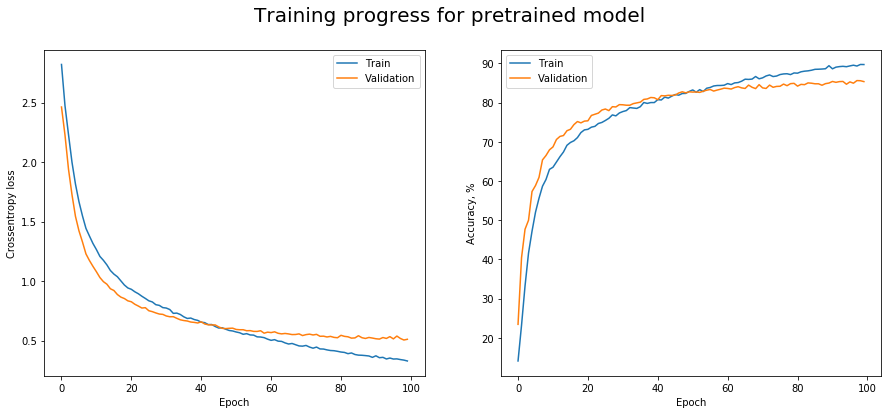

In [16]:
plt.figure(figsize=(15, 6))
plt.suptitle("Training progress for pretrained model", fontsize=20)

plt.subplot(121)
plt.plot(hist_top["loss"], label="Train")
plt.plot(hist_top["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(np.array(hist_top["accuracy"]) * 100, label="Train")
plt.plot(np.array(hist_top["val_accuracy"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %")
plt.xlabel("Epoch");

In [17]:
y_pred = model_top.predict(X_valid)
y_pred = np.argmax(y_pred, axis = 1)

In [18]:
print(classification_report(y_valid, y_pred))
print("Accuracy = {:.1f}%".format(accuracy_score(y_valid, y_pred) * 100))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       182
           1       1.00      0.25      0.40         8
           2       0.80      0.85      0.82       124
           3       0.59      0.62      0.60        21
           4       0.87      0.87      0.87       268
           5       0.85      0.58      0.69        19
           6       0.83      0.91      0.87       238
           7       0.91      0.87      0.89       197
           8       0.62      0.56      0.59         9
           9       0.90      0.76      0.83        93
          10       0.00      0.00      0.00         1
          11       0.78      0.86      0.82        91
          12       1.00      0.20      0.33         5
          13       0.00      0.00      0.00         5
          14       0.59      0.54      0.57        24
          15       0.84      0.85      0.85       449
          16       0.92      0.95      0.94        99
          17       0.90    

D:\Anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Prepare the model for deployment

I then join the classification model back to the convolutional base and add an input layer of appropriate shape.

In [19]:
inp = Input(shape=(img_height, img_width, 3))
pretrained_output = model_pretrained(inp)
top_output = model_top(pretrained_output)

In [20]:
model_final = Model(inputs=[inp], outputs=[top_output])
model_final.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [21]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 9, 12, 512)        20024384  
_________________________________________________________________
top (Model)                  (None, 23)                811543    
Total params: 20,835,927
Trainable params: 20,835,927
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_final.save(os.path.join(models_path, "pretrained_full.model.h5"))

I then test the complete model using the validation set.

In [23]:
y_pred = model_final.predict_generator(valid_gen, valid_steps_per_epoch)
y_valid = np.array(valid_gen.classes)

In [24]:
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_valid, y_pred))
print("Accuracy = {:.1f}%".format(accuracy_score(y_valid, y_pred) * 100))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       182
           1       1.00      0.25      0.40         8
           2       0.80      0.85      0.82       124
           3       0.59      0.62      0.60        21
           4       0.87      0.87      0.87       268
           5       0.85      0.58      0.69        19
           6       0.83      0.91      0.87       238
           7       0.91      0.87      0.89       197
           8       0.62      0.56      0.59         9
           9       0.90      0.76      0.83        93
          10       0.00      0.00      0.00         1
          11       0.78      0.86      0.82        91
          12       1.00      0.20      0.33         5
          13       0.00      0.00      0.00         5
          14       0.59      0.54      0.57        24
          15       0.84      0.85      0.85       449
          16       0.92      0.95      0.94        99
          17       0.90    

I downloaded random Simpsons images from the internet to test using the model. Do note that the images would need to be preprocessed using the preprocess function of VGG19 before they can used by the model for prediction.

In [25]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, preprocess_input_fn, target_size=(img_height, img_width)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    preds = model.predict(x)

    return preds

In [26]:
img_path = 'data/test/bart_simpson_2.jpg'
pred_class = np.argmax(predict_image(model_final, img_path, preprocess_input), axis=1)[0]
target_names = list(train_gen.class_indices.keys())
print(target_names[pred_class])

bart_simpson
